In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from esn import *

JAX requires the use of a PRNG (pseudo random number generator) key

In [2]:
key = jax.random.PRNGKey(1)

### Helper functions

In [3]:
def plot_inputs(ut):
    fig, axs = plt.subplots(len(ut), 1, figsize=(12, 3), dpi=200, sharex=True, sharey=True)
    for i in range(len(ut)):
        axs[i].plot(ut[i])
    plt.tight_layout();

In [4]:
def v_harvest_states(ut):
    xt, yt = [None]*3, [None]*3
    for i in range(len(ut)):
        xt[i], yt[i] = esn.harvest_states(ut[i])
    return xt, yt

In [5]:
def plot_input_output_list(ut: list, yt: list):
    fig, axs = plt.subplots(len(ut), 1, figsize=(12, 3), sharex=True, dpi=200)
    for i in range(len(ut)):
        axs[i].plot(ut[i], linestyle='-')
        axs[i].plot(yt[i], linestyle='--')
    plt.tight_layout();

In [6]:
def plot_input_output(ut: list, yt: list):
    fig, ax = plt.subplots(1, 1, figsize=(12, 2), sharex=True, dpi=200)
    ax.plot(ut, linestyle='-')
    ax.plot(yt, linestyle='--')
    plt.tight_layout();

### Input signal

In [7]:
def sine(T, dt, a=1.0, b=0.0, c=1.0):
    return a * jnp.sin(b * jnp.arange(0, T, dt) - c * jnp.pi).reshape(-1, 1)

In [8]:
ut = [
    sine(150, 0.1, 0.6, 0.5, 1.0),
    sine(150, 0.1, 1.0, 1.0, 1.0),
    sine(150, 0.1, 1.2, 1.8, 1.0)    
]

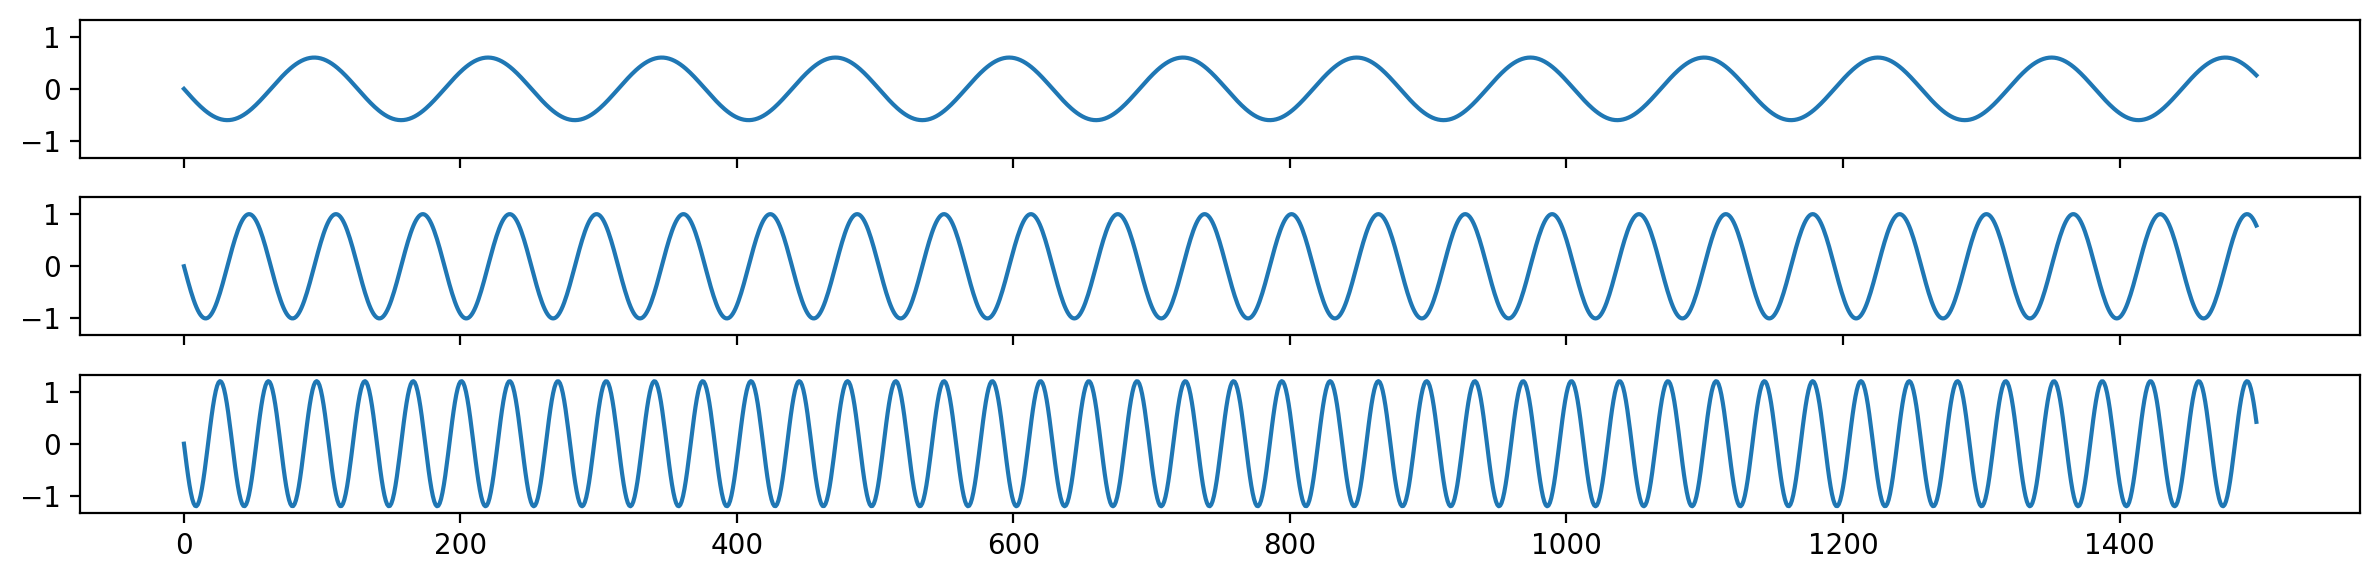

In [9]:
plot_inputs(ut)

### Collect states

In [10]:
config = ESNConfig(
    input_size     = ut[0].shape[1], 
    reservoir_size = 10, 
    output_size    = ut[0].shape[1], 
    init_weights   = jax.random.uniform, 
    rho            = 1.5, 
    feedback       = False
)

In [11]:
esn = ESN(key, config)

Feed patterns and collect states

In [12]:
xt, yt = v_harvest_states(ut)
print(f'xt: {len(xt)} x {xt[0].shape}')
print(f'yt: {len(yt)} x {yt[0].shape}')

xt: 3 x (1500, 10)
yt: 3 x (1500, 1)


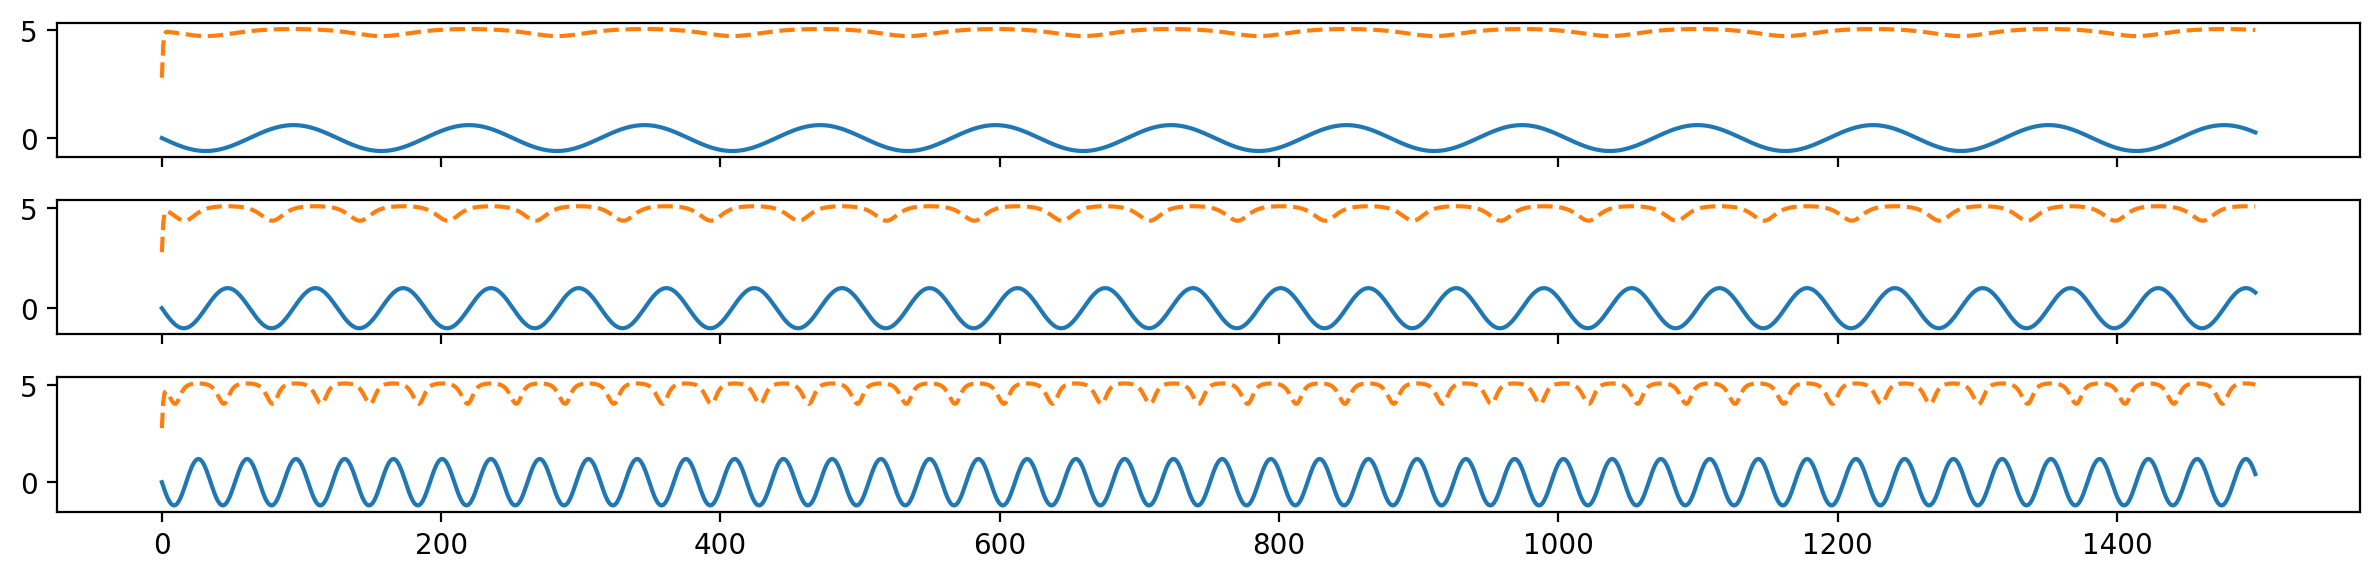

In [13]:
plot_input_output_list(ut, yt)

### Compute output weights

Make matrices: skip washout

In [14]:
def concatenate_patterns(xt, washout, shift=0):
    return jnp.concatenate([xt[i][washout+shift : xt[i].shape[0]+shift, :] for i in range(len(xt))])

In [15]:
T_washout = 500

In [16]:
X  = concatenate_patterns(xt, T_washout)
X_ = concatenate_patterns(xt, T_washout, shift=-1)
U  = concatenate_patterns(ut, T_washout)
print(f'X:  {X.shape}\nX_: {X_.shape}\nU:  {U.shape}')

X:  (3000, 10)
X_: (3000, 10)
U:  (3000, 1)


Compute the output weights

In [17]:
opt = RidgeRegression(alpha=0.01)
esn.update_weights(X, U, U.copy(), optimizer=opt)

Feed patterns and collect states

In [18]:
xt_trained, yt_trained = v_harvest_states(ut)

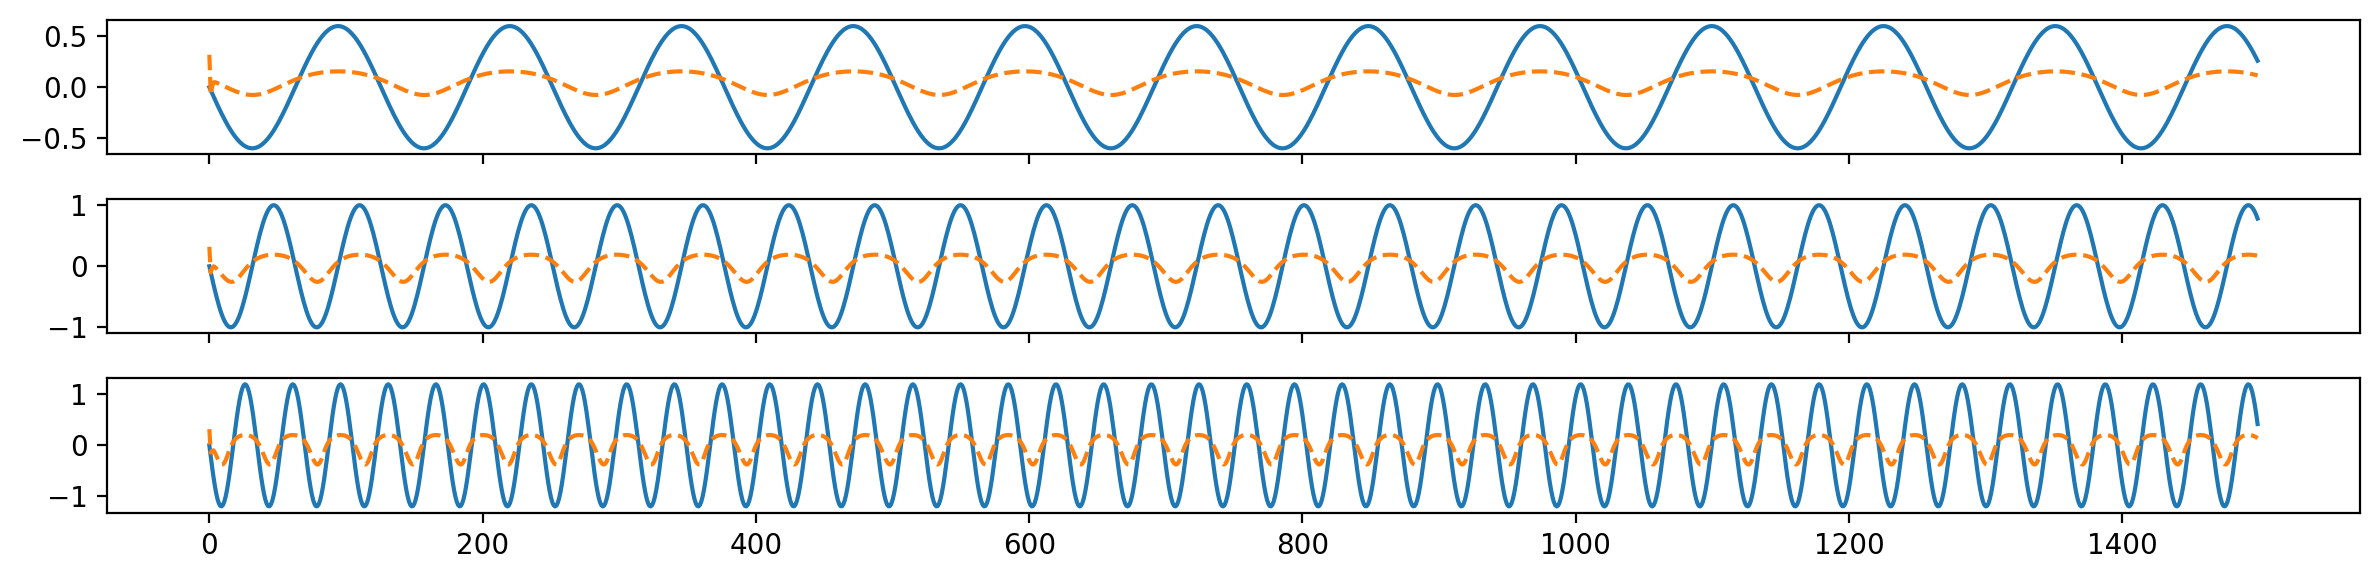

In [19]:
plot_input_output_list(ut, yt_trained)

### Load reservoir

Make matrices $X$, $\tilde X$ and $U$

In [20]:
X  = concatenate_patterns(xt_trained, T_washout)
X_ = concatenate_patterns(xt_trained, T_washout, shift=-1)
U  = concatenate_patterns(ut, T_washout)
Y  = concatenate_patterns(yt_trained, T_washout)
print(f'X:  {X.shape}\nX_: {X_.shape}\nU:  {U.shape}')

X:  (3000, 10)
X_: (3000, 10)
U:  (3000, 1)


Load the reservoir by optimizing
$$
W_i = \text{argmin}_{\tilde W_i} \sum_{j=1,\ldots,K} \sum_{n=1,\ldots,L} \left[ W_i^* x^j(n) + W_i^{in} p^j (n+1) - \tilde W_i x^j(n) \right]^2
$$

where $j$ iterates over patterns and $n$ iterates over timesteps. Using ridge regression, this yields:

$$
W = \left[ (\tilde X \tilde X^T + \rho^W I)^{-1} \tilde X (\tanh^{-1}(X)-B) \right]^T
$$

where $B$ is the bias $b$, repeated over time steps.

In [21]:
N = esn.reservoir_size
T = X.shape[0]
B = jnp.repeat(esn.b, T, axis=1).T
rhoW = 0.0001
W_loaded = jnp.dot(
    jnp.linalg.inv(
        jnp.dot(X_.T, X_) + rhoW * jnp.eye(N)),
    jnp.dot(
        X_.T, 
        jnp.arctanh(X)-B))

Set the new reservoir weight matrix

In [22]:
oldW = esn.w.copy()
esn.W = W_loaded.copy()

Test the reservoir without input

In [23]:
ut_loaded_zero = jnp.zeros_like(U)
xt_loaded_zero, yt_loaded_zero = esn.harvest_states(ut_loaded_zero)

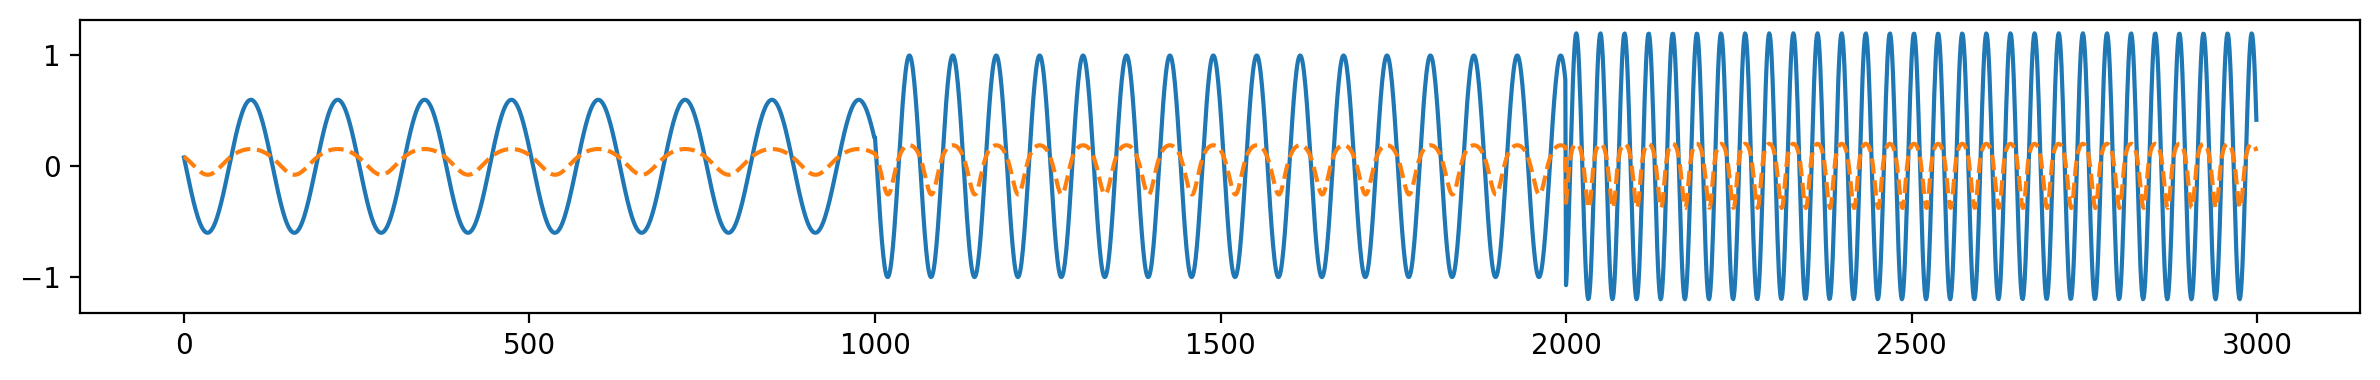

In [24]:
plot_input_output(U, Y)

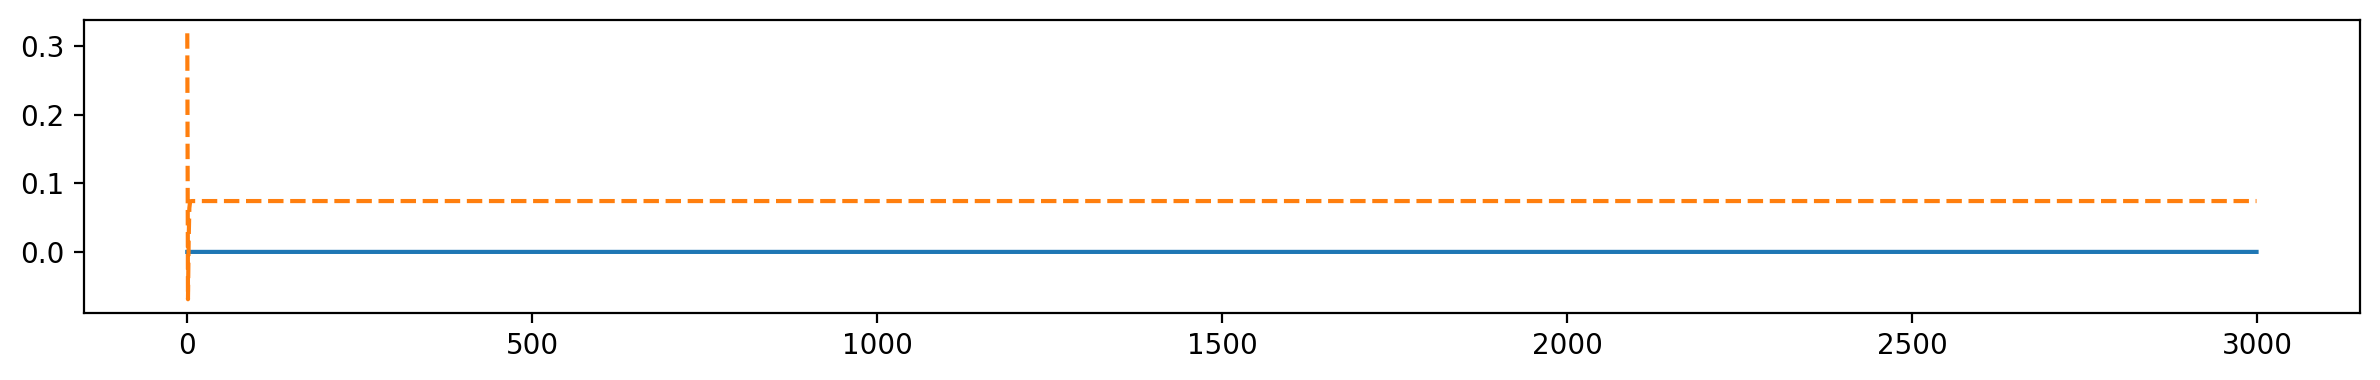

In [25]:
plot_input_output(ut_loaded_zero, yt_loaded_zero)

### Compute conceptors

In [26]:
xt_loaded, yt_loaded = v_harvest_states(ut)
print(f'xt_loaded: {len(xt_loaded)} x {xt_loaded[0].shape}')

xt_loaded: 3 x (1500, 10)


In [27]:
aperture = 10.0

In [28]:
Xi = [xt_loaded[i][T_washout : xt_loaded[i].shape[0], :] for i in range(len(xt_loaded))]

Compute the conceptors using the correlation matrix $R$ with:
$$
C(R, \alpha) = R (R + \alpha I)^{-1}
$$

In [29]:
Ci = []
for i in range(len(Xi)):
    X = Xi[i]
    R = jnp.dot(X.T, X) / X.shape[0]
    C = jnp.dot(
        R,
        jnp.linalg.inv(R + aperture ** (-2) * jnp.eye(R.shape[0]))
    )
    Ci.append(C)
print(f'Ci: {len(Ci)} x {Ci[0].shape}')

Ci: 3 x (10, 10)


Insert conceptor into forward loop:

In [30]:
ut_zero = jnp.zeros_like(U)
x_init = jax.random.uniform(key, (N, 1))
xt_conceptor, yt_conceptor = esn.harvest_states(ut_zero, x_init=x_init, C=Ci[1])

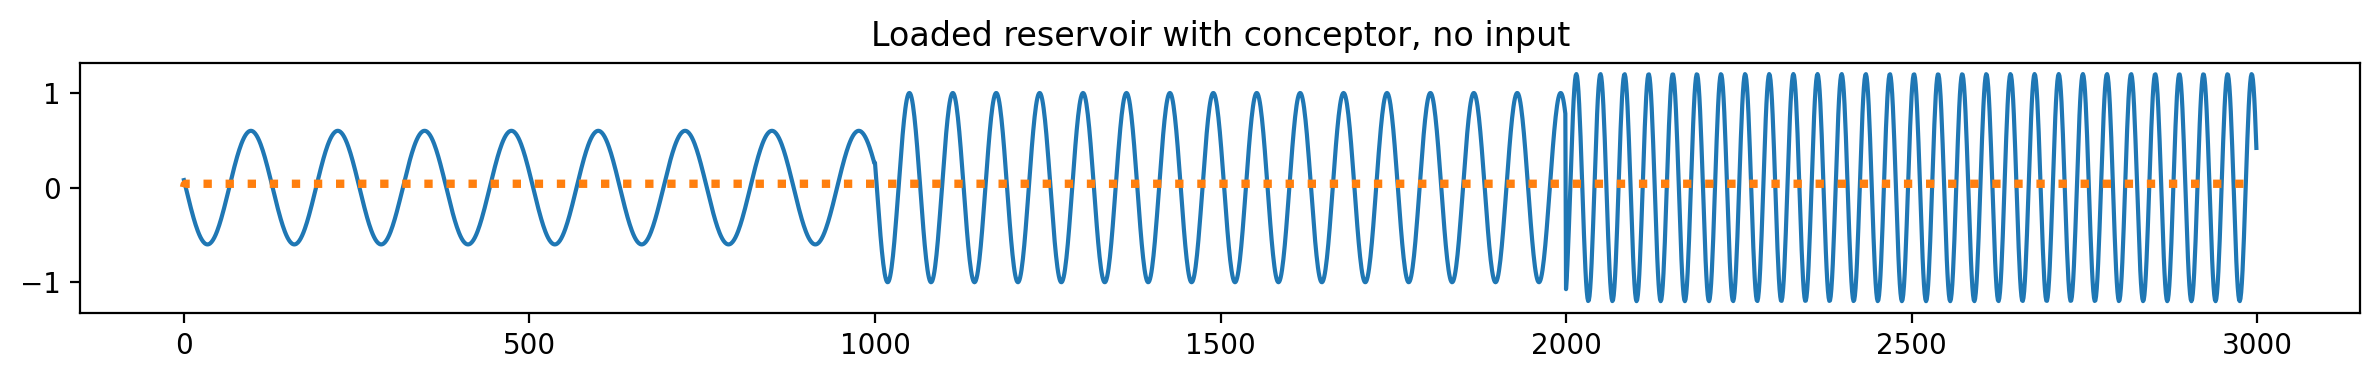

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(12, 2), sharex=True, dpi=200)
ax.set_title('Loaded reservoir with conceptor, no input')
ax.plot(U, linestyle='-', label='desired output')
ax.plot(yt_conceptor, linestyle=':', linewidth=3, label='output')
plt.tight_layout()
# plt.xlim(0,500)
plt.show()